In [1]:
import pandas as pd
import mplfinance as mpf
import rbot


In [3]:
bb = rbot.DummyBb()
bb.log_load(100)
ohlcv = bb.ohlcv(0, bb.log_end_ms, 60*60 * 2)
ohlcv_df = rbot.array_to_df(ohlcv)
ohlcv_df


,open,high,low,close,volume
timestamp,,,,,
2022-03-20 00:00:00+00:00,42215.0,42285.5,41800.0,41974.5,103775524.0
2022-03-20 02:00:00+00:00,41974.0,42050.0,41788.0,41940.0,62268670.0
2022-03-20 04:00:00+00:00,41940.5,41985.0,41766.5,41916.0,38393301.0
2022-03-20 06:00:00+00:00,41915.5,42020.0,41757.5,41859.5,94436560.0
2022-03-20 08:00:00+00:00,41859.5,41947.5,41588.5,41777.0,85057840.0
...,...,...,...,...,...
2022-06-27 14:00:00+00:00,20712.5,20827.0,20564.5,20730.0,145672751.0
2022-06-27 16:00:00+00:00,20727.0,20775.5,20632.0,20695.0,38109346.0
2022-06-27 18:00:00+00:00,20695.0,20918.5,20463.0,20825.0,152334272.0


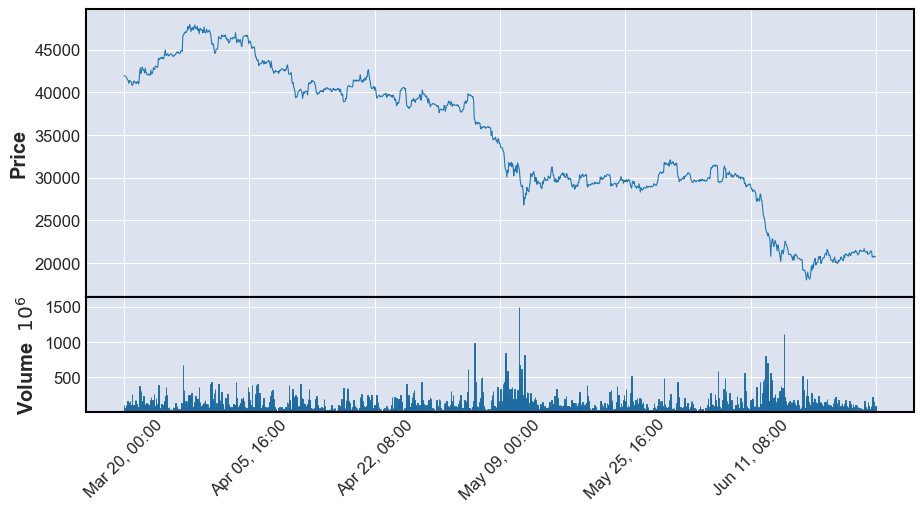

In [5]:
mpf.plot(ohlcv_df, type='line', volume=True, figratio=(16,8))

In [100]:
class Agent:
    def __init__(self, param_K=1.6):
        self.K = param_K                           # パラメターKを設定する。

    def on_clock(self, time_ms: int, session):# 指定時間毎に呼び出される（今回は２H相当時間毎）
        ohlcv_array = session.ohlcv(60*60*2, 6)     # 最新足０番目　＋　５本の足を取得。 最新は６番目。
        ohlcv_df = rbot.array_to_df(ohlcv_array)    # ndarrayをDataFrameへ変換

        if len(ohlcv_df.index) < 6:                 # データが過去６本分そろっていない場合はなにもせずリターン
            return 

        ohlcv_df["range"] = ohlcv_df["high"] - ohlcv_df["low"]      # レンジを計算

        ohlcv_latest = ohlcv_df[-2:-1]     # 最新足１本
        ohlcv_last_5 = ohlcv_df[:-2]       # 過去５本足

        range_width = ohlcv_last_5["range"].mean()      #　過去５本足のレンジの平均値

        # Long/Short判定
        detect_short = range_width * self.K < ohlcv_latest["high"][0] - ohlcv_latest["open"][0]
        detect_long  = range_width * self.K < ohlcv_latest["open"][0] - ohlcv_latest["low"][0]

        #　執行方法（順報告のポジションがあったら保留。逆方向のポジションがのこっていたらドテン）
        if detect_long: #long判定
            if not session.long_pos_size: #　既存のポジションがないこと
                if not session.short_pos_size:  # ショートのポジションがない場合は通常。ある場合はドテン。
                    return rbot.Order("Buy", session.buy_edge_price, 10, 600, "open long")    
                else:
                    return rbot.Order("Buy", session.buy_edge_price, 20, 600, "DOTEN Long")    
            else:
                pass

        if detect_short:
            if not session.short_pos_size:
                if not session.long_pos_size:
                    return rbot.Order("Sell", session.sell_edge_price, 10, 600, "open short") 
                else:
                    return rbot.Order("Sell", session.sell_edge_price, 20, 600, "DOTEN Short") 
            else:
                pass
  


In [101]:
agent = Agent()
result = bb.run(agent, 60*60*2)

df = rbot.result_to_df(result)

call back tick by 7200[sec]
Order! <rbot.Order object at 0x131578490>
ORDER: Buy 40940 600000
Order! <rbot.Order object at 0x131578800>
ORDER: Sell 42871 600000
Order! <rbot.Order object at 0x131578530>
ORDER: Buy 47434 600000
Order! <rbot.Order object at 0x131578e90>
ORDER: Sell 46446 600000
Order! <rbot.Order object at 0x13170b0d0>
ORDER: Buy 45812.5 600000
Order! <rbot.Order object at 0x13170b580>
ORDER: Sell 46456.5 600000
Order! <rbot.Order object at 0x13170b530>
ORDER: Buy 46275 600000
Order! <rbot.Order object at 0x13170b6c0>
ORDER: Sell 45745.5 600000
Order! <rbot.Order object at 0x13170b8f0>
ORDER: Buy 45935 600000
Order! <rbot.Order object at 0x13075b170>
ORDER: Sell 42992 600000
Order! <rbot.Order object at 0x13170b2b0>
ORDER: Buy 42136.5 600000
Order! <rbot.Order object at 0x13075bf80>
ORDER: Sell 41141.5 600000
Order! <rbot.Order object at 0x13233ce90>
ORDER: Buy 39946.5 600000
Order! <rbot.Order object at 0x13233c530>
ORDER: Sell 40418.5 600000
Order! <rbot.Order object a

In [102]:
result_df = rbot.result_to_df(result)
result_df = result_df.set_index("create_time", drop=True)

In [103]:
result_df

,timestamp,order_id,sub_id,order_type,post_only,status,open_price,close_price,size,volume,profit,fee,total_profit,pos_change,message,sum_profit,sum_pos
create_time,,,,,,,,,,,,,,,,,
2022-03-21 05:59:59+00:00,2022-03-21 06:01:06+00:00,0000-0001,0,Buy,True,Open,40940.0,0.0,10.0,0.000244,0.000000,0.006,-0.006000,10.0,open long,-0.006000,10.0
2022-03-22 05:59:59+00:00,2022-03-22 06:00:08+00:00,0000-0002,0,Sell,True,Close,40940.0,42871.0,10.0,0.000233,-0.450421,0.006,-0.456421,-10.0,DOTEN Short,-0.462421,0.0
2022-03-22 05:59:59+00:00,2022-03-22 06:00:08+00:00,0000-0002,1,Sell,True,Open,42871.0,0.0,10.0,0.000233,0.000000,0.006,-0.006000,-10.0,DOTEN Short,-0.468421,-10.0
2022-03-30 03:59:57+00:00,2022-03-30 04:00:00+00:00,0000-0003,0,Buy,True,Close,42871.0,47434.0,10.0,0.000211,0.961968,0.006,0.955968,10.0,DOTEN Long,0.487547,0.0
2022-03-30 03:59:57+00:00,2022-03-30 04:00:00+00:00,0000-0003,1,Buy,True,Open,47434.0,0.0,10.0,0.000211,0.000000,0.006,-0.006000,10.0,DOTEN Long,0.481547,10.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-06-13 03:59:57+00:00,2022-06-13 04:00:01+00:00,0000-0050,1,Buy,True,Open,25455.0,0.0,10.0,0.000393,0.000000,0.006,-0.006000,10.0,DOTEN Long,-0.171529,10.0
2022-06-18 23:59:59+00:00,2022-06-19 00:00:09+00:00,0000-0051,0,Sell,True,Close,25455.0,18942.5,10.0,0.000528,3.438036,0.006,3.432036,-10.0,DOTEN Short,3.260507,0.0
2022-06-18 23:59:59+00:00,2022-06-19 00:00:09+00:00,0000-0051,1,Sell,True,Open,18942.5,0.0,10.0,0.000528,0.000000,0.006,-0.006000,-10.0,DOTEN Short,3.254507,-10.0


In [96]:
chart = pd.merge_asof(ohlcv_df, df, left_on="timestamp", right_on="create_time", direction="nearest")



In [97]:
chart

,open,high,low,close,volume_x,timestamp,order_id,sub_id,order_type,post_only,...,close_price,size,volume_y,profit,fee,total_profit,pos_change,message,sum_profit,sum_pos
0,42215.0,42285.5,41800.0,41974.5,103775524.0,2022-03-21 06:01:06+00:00,0000-0001,0,Buy,True,...,0.0,10.0,0.000244,0.0,0.006,-0.006,10.0,Open Long,-0.006000,10.0
1,41974.0,42050.0,41788.0,41940.0,62268670.0,2022-03-21 06:01:06+00:00,0000-0001,0,Buy,True,...,0.0,10.0,0.000244,0.0,0.006,-0.006,10.0,Open Long,-0.006000,10.0
2,41940.5,41985.0,41766.5,41916.0,38393301.0,2022-03-21 06:01:06+00:00,0000-0001,0,Buy,True,...,0.0,10.0,0.000244,0.0,0.006,-0.006,10.0,Open Long,-0.006000,10.0
3,41915.5,42020.0,41757.5,41859.5,94436560.0,2022-03-21 06:01:06+00:00,0000-0001,0,Buy,True,...,0.0,10.0,0.000244,0.0,0.006,-0.006,10.0,Open Long,-0.006000,10.0
4,41859.5,41947.5,41588.5,41777.0,85057840.0,2022-03-21 06:01:06+00:00,0000-0001,0,Buy,True,...,0.0,10.0,0.000244,0.0,0.006,-0.006,10.0,Open Long,-0.006000,10.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1195,20712.5,20827.0,20564.5,20730.0,145672751.0,2022-06-26 16:00:10+00:00,0000-0052,1,Buy,True,...,0.0,10.0,0.000469,0.0,0.006,-0.006,10.0,doten Long,4.380467,10.0
1196,20727.0,20775.5,20632.0,20695.0,38109346.0,2022-06-26 16:00:10+00:00,0000-0052,1,Buy,True,...,0.0,10.0,0.000469,0.0,0.006,-0.006,10.0,doten Long,4.380467,10.0
1197,20695.0,20918.5,20463.0,20825.0,152334272.0,2022-06-26 16:00:10+00:00,0000-0052,1,Buy,True,...,0.0,10.0,0.000469,0.0,0.006,-0.006,10.0,doten Long,4.380467,10.0
1198,20825.0,20932.0,20754.0,20767.0,35212489.0,2022-06-26 16:00:10+00:00,0000-0052,1,Buy,True,...,0.0,10.0,0.000469,0.0,0.006,-0.006,10.0,doten Long,4.380467,10.0


In [98]:

from matplotlib.pyplot import ylabel


ap2 = [
    mpf.make_addplot(chart['sum_profit'], type='line', color='g', panel=2, ylabel="profit"),
    mpf.make_addplot(chart['sum_pos'], type='line', color='r', panel=3, ylabel="pos"),    
]

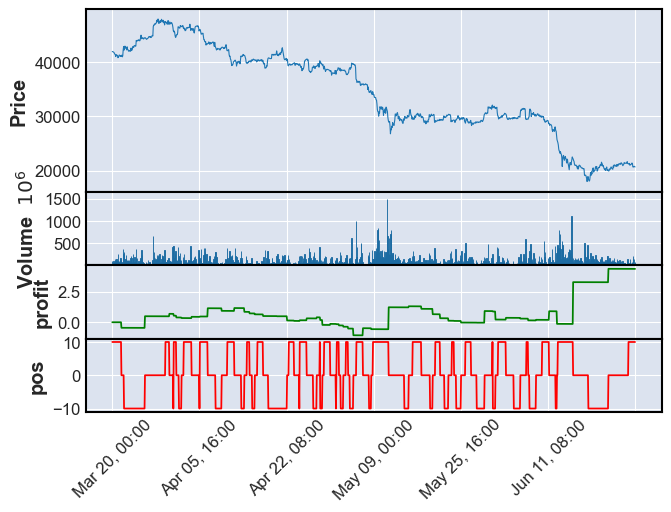

In [99]:
mpf.plot(ohlcv_df, volume=True, type='line', addplot=ap2)